# **Clickstream Analysis and Analysing User Behaviour On E-Commerce Website**


E-commerce has become a huge part of our lives. Within a touch of a button, we can order anything that we want from any corner of the world. There is a lot of information and algorithms that are implemented in order to process an order. While the E-commerce pipeline is extrememly intricate, we decided to focus on the initial user interaction with the product, that includes: **Discovery**, **Analysis** and **Checkout**
- **Discovery:** Various products are made visible to the user on the users' prefered interface (mobile application or website)
- **Analysis:** The user selects and chooses the product that best suits their requirements. The user wants to learn more about the product and make sure that all aspects of the product meets the requirements (product dimension, product color, estimated delivery dates, etc.)
- **Checkout:** The user then either adds the product to their cart and continues shopping, or proceed to check-out in order to put an order for the product. 


The three phases explained above are greatly linked to user experience and interaction (UX/UI) of the application. Having a good interface for an application greatly affects its usability among the users. If the discovery page interface is not well scripted, it would have implecations on product Discovery, which would result in low sales. If the checkout page interface is faulty, it would pose friction during the checkout process hindering product purchase.  

The objective of this study is to predict whether a user session will result in a transaction, based on the behavioural sequence and temporal features. By building a model grounded in user-item interaction over time data, we aim not only to support conversion rate optimisation but also to surface potential friction points in the user journey. 


## Dataset Information

We are using the E-commerce App Transactional Datasets from Kaggle (https://www.kaggle.com/datasets/bytadit/transactional-ecommerce). The following are the breakdown for the datasets:

### Customer Table
Containing the detailed information of registered user in ecommerce application

- customer_id = customer unique id
- first_name = customer's first name
- last_name = customer's last name
- username = customer's username
- email = customer's email
- gender = customer's gender (Male (M) or Female (F))
- device_type = the device type of customer when using the app
- device_id = device id of customer when using app
- device_version = detailed version of device used by customer
- home_location_lat = customer location latitude
- home_location_long =customer location longitude
- home_location = customer province/region name
- home_country = customer country name
- first_join_date = customer first join date in app

### Product Table
Containing the detailed data of product (fashion product) sold in application

- id = product id
- gender = target/designate products based on gender
- masterCategory = Master category of product
- subCategory = sub category of product
- articleType = fashion product type
- baseColour = base color of fashion product
- season = target/designate products based on season
- year = the year of production
- usage = the usage type of product
- productDisplayName = the display name of product in ecommerce app

### Transaction Table
contains data for each transaction/product order made by the customer. Each customer can make multiple purchases on multiple products.

- created_at = the timestamp when data/transaction created
- customer_id = unique id of every customer
- booking_id = unique id of transaction
- session_id = unique session id of user when visiting the app
- product_metadata = the metadata of product purchased
- payment_method = the payment method used in transaction
- payment_status = the payment status (Success / Failed)
- promo_amount = the amount of promo in every transacation
- promo_code =promo code
- shipment_fee = the shipment fee of transaction (ongkir)
- shipment_date_limit = the shipment limit data
- shipment_location_lat = the shipment location/target latitude
- shipment_location_long = the shipment location/target longitude
- total_amount = total amount of money to be paid for every transaction

### Click Stream Table
contains data on application usage activities carried out by users in each session or when they make a transaction

- session_id = session id
- event_name = the name of activity/event
- event_time = the time when event occured
- event_id = id of event
- traffic_source = the activity source by device (mobile/web)
- event_metadata = the metadata of activity / detailed activity


### Model Development: Data Import and Initial Inspection

This section reads four datasets (click_stream.csv, transactions.csv, customer.csv, and product.csv) into pandas DataFrames using read_csv().We started by processing all 4 datasets and seeing the information they hold. Certain features of the dataset were not relevant to our dataset and hence we decided to remove them. 

In [3]:
import pandas as pd

# Load all required CSV files into pandas DataFrames
df_click = pd.read_csv('click_stream.csv')
df_txn = pd.read_csv('transactions.csv')
df_user = pd.read_csv('customer.csv')
df_prod = pd.read_csv('product.csv', on_bad_lines='skip')


# Check the dataset
print("click_stream.csv:")
print(df_click.info(), "\n")
print(df_click.isnull().sum(), "\n")

print("transactions.csv:")
print(df_txn.info(), "\n")
print(df_txn.isnull().sum(), "\n")

print("customer.csv:")
print(df_user.info(), "\n")
print(df_user.isnull().sum(), "\n")

print("product.csv:")
print(df_prod.info(), "\n")
print(df_prod.isnull().sum(), "\n")

click_stream.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   session_id      object
 1   event_name      object
 2   event_time      object
 3   event_id        object
 4   traffic_source  object
 5   event_metadata  object
dtypes: object(6)
memory usage: 587.5+ MB
None 

session_id              0
event_name              0
event_time              0
event_id                0
traffic_source          0
event_metadata    8544062
dtype: int64 

transactions.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852584 entries, 0 to 852583
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              852584 non-null  object 
 1   customer_id             852584 non-null  int64  
 2   booking_id              852584 non-null  object 
 3   session_id          

### Model Development: Data Cleaning and Preprocessing

This section of code performs initial cleaning across the datasets to ensure consistency. It also handles missing or incorrectly formatted data. 
- Missing values in the promo_code field of the df_txn are filled with "none"
- Missing categorical fields in the df_prod such as baseColour, season, usage, and productDisplayName are replaced with "unknown"
- several date-related columns across datasets (created_at, shipment_date_limit, event_time, birthdate, and first_join_date) are converted to datetime objects to enable time-based operations. 
- Invalid date entries are safely handled using errors='coerce', converting them to NaT (Not a Time).

This code also processes clickstream data to generate a session-level label for purchase activity while removing unrealistic sessions.

- It first groups events by session_id to calculate each session’s start and end times, then computes the duration in seconds.

- Sessions lasting more than one hour (> 3600 seconds) are considered too long and are removed from the dataset.

- For the remaining sessions, it aggregates the buy_flag values, taking the maximum to assign a purchase label (1 if any purchase occurred in that session, otherwise 0).
- The result is a clean session-level dataset with a binary label indicating purchase behavior.

In [4]:
# Data Cleaning and Preprocessing

df_txn['promo_code'] = df_txn['promo_code'].fillna('none')
df_txn['created_at'] = pd.to_datetime(df_txn['created_at'])
df_txn['shipment_date_limit'] = pd.to_datetime(df_txn['shipment_date_limit'])

# Convert event_time to datetime
df_click['event_time'] = pd.to_datetime(df_click['event_time'])

# Remove rows with missing event_metadata
df_click = df_click[df_click['event_metadata'].notna()]
df_click['buy_flag'] = df_click['event_metadata'].str.contains("'payment_status': 'Success'", case=False, na=False).astype(int)
print(df_click['event_metadata'].value_counts().head(50))


df_user['birthdate'] = pd.to_datetime(df_user['birthdate'], errors='coerce')
df_user['first_join_date'] = pd.to_datetime(df_user['first_join_date'], errors='coerce')

df_prod['baseColour'] = df_prod['baseColour'].fillna('unknown')
df_prod['season'] = df_prod['season'].fillna('unknown')
df_prod['usage'] = df_prod['usage'].fillna('unknown')
df_prod['productDisplayName'] = df_prod['productDisplayName'].fillna('unknown')

# Create session-level label
session_duration_df = df_click.groupby('session_id').agg(
    start=('event_time', 'min'),
    end=('event_time', 'max')
)
session_duration_df['duration'] = (session_duration_df['end'] - session_duration_df['start']).dt.total_seconds()
too_long_sessions = session_duration_df[session_duration_df['duration'] > 3600].index
df_click = df_click[~df_click['session_id'].isin(too_long_sessions)]
session_label = df_click.groupby('session_id')['buy_flag'].max().reset_index()
session_label.columns = ['session_id', 'label']  # 1=buy, 0=not buy

event_metadata
{'payment_status': 'Success'}                      815962
{'search_keywords': 'Dress Kondangan'}             256194
{'search_keywords': 'Tas Wanita'}                  128790
{'search_keywords': 'Bekas'}                       112269
{'search_keywords': 'T-Shirt'}                     100087
{'search_keywords': 'Baju'}                         83873
{'search_keywords': 'Kaos'}                         83759
{'search_keywords': 'Dress Pesta'}                  76829
{'search_keywords': 'Sepatu Nike'}                  51578
{'search_keywords': 'Tas Kerja'}                    38677
{'payment_status': 'Failed'}                        36620
{'search_keywords': 'Second Hand'}                  28429
{'search_keywords': 'Second'}                       28195
{'search_keywords': 'Thrift'}                       28171
{'search_keywords': 'Sepatu'}                       28029
{'search_keywords': 'Celana Panjang'}               28009
{'search_keywords': 'Barang Bekas'}                 27818

In [5]:
# Check the cleaned data
print(df_click['session_id'].nunique(), df_txn['session_id'].nunique())
print(df_txn['customer_id'].nunique(), df_user['customer_id'].nunique())
print(df_txn['product_metadata'].head())

94588 852584
50705 100000
0    [{'product_id': 54728, 'quantity': 1, 'item_pr...
1    [{'product_id': 16193, 'quantity': 1, 'item_pr...
2    [{'product_id': 53686, 'quantity': 4, 'item_pr...
3    [{'product_id': 20228, 'quantity': 1, 'item_pr...
4    [{'product_id': 55220, 'quantity': 1, 'item_pr...
Name: product_metadata, dtype: object


### Model Development: Safely Parsing and Expanding Product Metadata
This code ensures that the product_metadata column in the transactions dataset (df_txn) is safely converted from string format into usable Python objects. A custom function, safe_eval, attempts to parse strings into Python lists/dictionaries using ast.literal_eval, returning None if parsing fails or if the value is invalid. 

Once converted, the list of products in each transaction is expanded into separate rows with explode, so each product gets its own row. Key attributes—product_id, quantity, and item_price—are extracted into individual columns, and the original nested product_metadata column is removed to simplify the dataset.

In [6]:

# Safe Conversion of product_metadata Strings to Python Lists

import ast

def safe_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except:
            return None
    elif isinstance(val, list):
        return val
    else:
        return None

df_txn['product_metadata'] = df_txn['product_metadata'].apply(safe_eval)

df_txn_exploded = df_txn.explode('product_metadata', ignore_index=True)

df_txn_exploded['product_id'] = df_txn_exploded['product_metadata'].apply(lambda x: x.get('product_id') if isinstance(x, dict) else None)
df_txn_exploded['quantity'] = df_txn_exploded['product_metadata'].apply(lambda x: x.get('quantity') if isinstance(x, dict) else None)
df_txn_exploded['item_price'] = df_txn_exploded['product_metadata'].apply(lambda x: x.get('item_price') if isinstance(x, dict) else None)

# Drop the nested metadata column
df_txn_exploded.drop(columns=['product_metadata'], inplace=True)


### Model Development: Merging Datasets for Integrated Analysis

This code sequentially merges the df_click, df_txn, df_user, and df_prod datasets into a single, comprehensive dataframe.

- Clickstream data is merged with key transaction details (payment_status, customer_id) using session_id as the join key.
- User profile data is added via customer_id to enrich each record with user attributes.
- Expanded product-level transaction data (df_txn_exploded) is merged in using session_id, linking clicks to the products involved.
- detailed product information from df_prod is merged in using product_id and id.
The result, stored in df_click_txn_user_prod, is a combined dataset containing click events, transaction status, customer details, and product information, ready for further analysis.

In [7]:
# Merge DataFrames

df_click_txn = df_click.merge(df_txn[['session_id', 'payment_status', 'customer_id']], on='session_id', how='left')

df_click_txn_user = df_click_txn.merge(df_user, on='customer_id', how='left')

df_click_txn_user_prod = df_click_txn_user.merge(df_txn_exploded[['session_id', 'product_id']], on='session_id', how='left')
df_click_txn_user_prod = df_click_txn_user_prod.merge(df_prod, left_on='product_id', right_on='id', how='left')

df_click_txn_user_prod = df_click_txn_user_prod.copy()

In [8]:
df_click_txn_user_prod.to_csv('full_session_dataset.csv', index=False)
# save it as csv file to prevent re-running the merge.

In [9]:
#Check the final dataset
print("Dataset shape:", df_click_txn_user_prod.shape)
print("Columns:\n", df_click_txn_user_prod.columns.tolist())

Dataset shape: (697662, 34)
Columns:
 ['session_id', 'event_name', 'event_time', 'event_id', 'traffic_source', 'event_metadata', 'buy_flag', 'payment_status', 'customer_id', 'first_name', 'last_name', 'username', 'email', 'gender_x', 'birthdate', 'device_type', 'device_id', 'device_version', 'home_location_lat', 'home_location_long', 'home_location', 'home_country', 'first_join_date', 'product_id', 'id', 'gender_y', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']


### Feature Engineering: : Creating a Binary Conversion Flag and Calculating Conversion Rate

This code identifies successful purchase events directly from the clickstream data by checking if the event_metadata field contains the text "'payment_status': 'Success'". 

- The result is stored in a new converted column, where 1 indicates a successful payment and 0 otherwise.

- Finally, the UX funnel-based conversion rate is calculated as the proportion of sessions that resulted in a conversion and printed.

In [10]:
# Create a Binary Conversion Flag

df_click['converted'] = df_click['event_metadata'].str.contains("'payment_status': 'Success'", case=False).astype(int)


session_converted = df_click.groupby('session_id')['converted'].max().reset_index()

# UX funnel-based conversion rate
conversion_rate = session_converted['converted'].mean()

print(f"UX funnel-based conversion rate: {conversion_rate:.4f}")

UX funnel-based conversion rate: 0.6661


### Feature Engineering: Event Counts per Session
This code aggregates user events by session, counting the number of occurrences for each event type within every session_id. The resulting table has one row per session and columns representing the count of each event type, with zeros filled in for events that did not occur. 



In [11]:
# 4A Feature Engineering: Event Counts per Session
event_counts = df_click_txn_user_prod.groupby(['session_id', 'event_name']).size().unstack(fill_value=0).reset_index()

event_counts.columns.name = None
event_counts.columns = ['session_id'] + [f'event_count_{col}' for col in event_counts.columns[1:]]

print(event_counts.head())


                             session_id  event_count_ADD_PROMO  \
0  00003eca-954b-4150-aee1-63fc62f395cf                      0   
1  00005746-17ec-449c-9c5c-699a3ea9304a                      0   
2  00007415-e0e7-4a33-95e8-5bc749016876                      0   
3  0000a158-a793-4f64-ba52-660a24ff8af6                      0   
4  00038f48-10a2-4752-bdcf-4d12b5731f6e                      0   

   event_count_ADD_TO_CART  event_count_BOOKING  event_count_SEARCH  
0                        1                    1                   0  
1                        1                    1                  11  
2                        1                    1                   9  
3                        2                    1                   0  
4                        1                    0                   0  


### Feature Engineering: Customer Demographics and Device Information
This code derives customer demographic and device-related features from the combined click–transaction–user–product dataset.

- Birthdates are converted to datetime, and age is calculated by subtracting the birth year from the event year.

- Records with unrealistic ages (outside the 10–100 range) are filtered out.

- Customers are grouped into categorical age ranges (<18, 18–25, 26–35, 36–45, 46–60, 60+) using pd.cut.

- A reduced feature set containing session_id, gender_x, device_type, and age_group is extracted, ensuring uniqueness per session.

Categorical features are then one-hot encoded with pd.get_dummies, creating binary indicator columns for each gender, device type, and age group.

In [12]:
#4B Feature Engineering: Customer Device Features

df_click_txn_user_prod['birthdate'] = pd.to_datetime(df_click_txn_user_prod['birthdate'], errors='coerce')
df_click_txn_user_prod['age'] = df_click_txn_user_prod['event_time'].dt.year - df_click_txn_user_prod['birthdate'].dt.year

df_click_user_prod = df_click_txn_user_prod[df_click_txn_user_prod['age'].between(10, 100)].copy()

age_bins = [0, 18, 25, 35, 45, 60, 100]
age_labels = ['<18', '18-25', '26-35', '36-45', '46-60', '60+']
df_click_user_prod['age_group'] = pd.cut(df_click_user_prod['age'], bins=age_bins, labels=age_labels)

customer_device_features = df_click_user_prod[['session_id', 'gender_x', 'device_type', 'age_group']].drop_duplicates()

customer_device_encoded = pd.get_dummies(customer_device_features,
    columns=['gender_x', 'device_type', 'age_group'],
    prefix=['gender', 'device', 'age']
)

print(customer_device_encoded.head())


                              session_id  gender_F  gender_M  device_Android  \
0   7d440441-e67a-4d36-b324-80ffd636d166      True     False            True   
3   57450e55-19b2-4633-a527-dfe93f5c65c4      True     False            True   
6   79b4a4c3-4877-4b4a-aadf-d8f85c5e8bab      True     False            True   
11  0581c17c-feb9-4665-aeb2-ca94519eda3d      True     False            True   
13  18da9200-2cb3-4dc9-b883-229cab577e49      True     False            True   

    device_iOS  age_<18  age_18-25  age_26-35  age_36-45  age_46-60  age_60+  
0        False     True      False      False      False      False    False  
3        False     True      False      False      False      False    False  
6        False     True      False      False      False      False    False  
11       False     True      False      False      False      False    False  
13       False     True      False      False      False      False    False  


### Feature Engineering: Product-Level Attributes
This code creates aggregated product-level features for each session from the combined dataset.

- Products viewed or purchased within the same session are grouped by session_id.

- For categorical attributes (baseColour, masterCategory, subCategory, articleType, season, usage), the most frequent value (mode) in each session is selected, defaulting to "Unknown" if no mode exists.

- The numeric attribute year is averaged across all products in the session.

- The resulting product features are one-hot encoded using pd.get_dummies, producing binary indicator columns for each possible category value.
The final product_features_encoded dataframe contains clean, model-ready product attribute features that summarize product interactions at the session level.

In [13]:
# 4C Feature Engineering: Product-level Features

product_features = df_click_txn_user_prod.groupby('session_id').agg({
    'baseColour': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'masterCategory': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'subCategory': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'articleType': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'season': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'year': 'mean',
    'usage': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
}).reset_index()

product_features_encoded = pd.get_dummies(
    product_features,
    columns=['baseColour', 'masterCategory', 'subCategory', 'articleType', 'season', 'usage'],
    prefix=['color', 'category', 'subcategory', 'type', 'season', 'usage']
)

print(product_features_encoded.shape)
print(product_features_encoded.head())

(94588, 263)
                             session_id    year  color_Beige  color_Black  \
0  00003eca-954b-4150-aee1-63fc62f395cf  2012.0        False         True   
1  00005746-17ec-449c-9c5c-699a3ea9304a  2011.0        False         True   
2  00007415-e0e7-4a33-95e8-5bc749016876  2012.0        False        False   
3  0000a158-a793-4f64-ba52-660a24ff8af6  2012.0        False        False   
4  00038f48-10a2-4752-bdcf-4d12b5731f6e     NaN        False        False   

   color_Blue  color_Bronze  color_Brown  color_Burgundy  color_Charcoal  \
0       False         False        False           False           False   
1       False         False        False           False           False   
2       False         False        False           False           False   
3       False         False        False           False           False   
4       False         False        False           False           False   

   color_Coffee Brown  ...  usage_Casual  usage_Ethnic  usage_Forma

### Feature Engineering: Temporal Attributes
This code extracts time-based features from session data to capture when user activity occurs.

- The event_time column is converted to datetime format to enable time operations.

- For each session_id, the earliest event time is selected as the session start time.

- From this start time, three temporal features are derived:

    -   day_of_week (0 = Monday, 6 = Sunday)

    -   hour_of_day (hour of the day, 0–23)

    -   week_of_month (week number within the month, calculated from the day)

- The resulting temporal_features dataframe contains one row per session with these temporal indicators, ready for use in downstream modeling.

In [14]:
#4D Feature Engineering: Temporal Features

df_click_txn_user_prod['event_time'] = pd.to_datetime(df_click_txn_user_prod['event_time'])

session_times = df_click_txn_user_prod.groupby('session_id')['event_time'].min().reset_index()

# 0=Monday, 6=Sunday
session_times['day_of_week'] = session_times['event_time'].dt.dayofweek  
session_times['hour_of_day'] = session_times['event_time'].dt.hour      
session_times['week_of_month'] = session_times['event_time'].apply(lambda x: (x.day - 1) // 7 + 1)

print(session_times[['session_id', 'event_time', 'day_of_week', 'hour_of_day', 'week_of_month']].head())

temporal_features = session_times[['session_id', 'day_of_week', 'hour_of_day', 'week_of_month']]

                             session_id                       event_time  \
0  00003eca-954b-4150-aee1-63fc62f395cf 2019-08-24 06:00:15.849738+00:00   
1  00005746-17ec-449c-9c5c-699a3ea9304a 2022-03-08 23:17:23.510057+00:00   
2  00007415-e0e7-4a33-95e8-5bc749016876 2022-07-24 13:12:25.038087+00:00   
3  0000a158-a793-4f64-ba52-660a24ff8af6 2020-07-02 03:44:31.229360+00:00   
4  00038f48-10a2-4752-bdcf-4d12b5731f6e 2021-01-16 16:59:24.918402+00:00   

   day_of_week  hour_of_day  week_of_month  
0            5            6              4  
1            1           23              2  
2            6           13              4  
3            3            3              1  
4            5           16              3  


### Feature Engineering: Session-Level Interaction Metrics
This code generates behavioral features that summarize user activity within each session.

- It aggregates the clickstream data by session_id to compute:

    - num_events – total number of recorded events in the session.

    - session_duration – length of the session in seconds (from first to last event).

    - first_hour – hour of day when the session started.

    -  weekday – day of week the session began (0 = Monday, 6 = Sunday).

- The resulting session-level features are then merged with session_label, which contains the binary purchase outcome for each session.
This produces a combined session_df with both interaction metrics and purchase labels for use in modeling and analysis.



In [15]:
# 4E Feature Engineering: Session-level Features
session_features = df_click.groupby('session_id').agg(
    num_events=('event_name', 'count'),
    session_duration=('event_time', lambda x: (x.max() - x.min()).total_seconds()),
    first_hour=('event_time', lambda x: x.min().hour),
    weekday=('event_time', lambda x: x.min().weekday())
).reset_index()

session_df = session_features.merge(session_label, on='session_id', how='outer')

In [16]:
# List of all feature DataFrames to be merged 

from functools import reduce
dfs = [event_counts, customer_device_encoded, product_features_encoded, temporal_features]
df_features = reduce(lambda left, right: pd.merge(left, right, on='session_id', how='outer'), dfs)

df_final = df_features.merge(session_label, on='session_id', how='left')

# Export the complete dataset for model training
df_final.to_csv('final_project_features.csv', index=False)

### Model Training, Evaluation, and Comparison
This code trains and evaluates two classification models—Logistic Regression and Random Forest—to predict session-level purchase behavior.

- The feature dataset is loaded from final_project_features.csv, and rows with missing values are removed.

- Features (X) are separated from the target label (y), and StandardScaler is applied to normalize feature values.

- The data is split into training (80%) and testing (20%) sets with stratified sampling to preserve class balance.

- Logistic Regression is trained with balanced class weights and a maximum of 1,000 iterations.

- Random Forest is trained with tuned hyperparameters (e.g., n_estimators=200, max_depth=10) and balanced class weights.

- Both models are evaluated on the test set using Accuracy, F1-score, and AUC (Area Under the ROC Curve).

- Results are stored in a dataframe for comparison, printed to the console, and saved as model_results.csv for future reference.

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

df = pd.read_csv('final_project_features.csv')

# data cleaning before model training

df_clean = df.dropna()

X = df_clean.drop(columns=['session_id', 'label'])
y = df_clean['label']

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


# Logistic Regression Model

# Logistic Regression with balanced class weights
logreg = LogisticRegression(class_weight='balanced',max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logreg_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])


# Random Forest Model

# Random Forest with hyperparameters tuned
rf = RandomForestClassifier(
    n_estimators=200,         
    max_depth=10,              
    min_samples_split=5,       
    min_samples_leaf=3,        
    max_features='sqrt',      
    class_weight='balanced',  
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# Compare Results
results = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_test, y_pred_logreg),
        'F1-score': f1_score(y_test, y_pred_logreg),
        'AUC': logreg_auc
    },
    {
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'F1-score': f1_score(y_test, y_pred_rf),
        'AUC': rf_auc
    }
])

print(results)

results.to_csv('model_results.csv', index=False)

                 Model  Accuracy  F1-score       AUC
0  Logistic Regression  0.527716  0.681687  0.512341
1        Random Forest  0.725293  0.838538  0.511011


### Visualizing: Feature Correlations
This code generates a heatmap to visualize correlations between numerical features in the cleaned dataset.

- Non-feature columns (session_id, label) are removed to isolate predictor variables.

- A correlation matrix is computed using Pearson correlation coefficients.

- Seaborn’s heatmap is used to display the matrix, with a diverging color scale (coolwarm) centered at zero to highlight positive and negative correlations.

- Plot formatting includes a larger figure size, square cells, adjusted color bar, and rotated axis labels for readability.

The resulting visualization helps identify relationships and multicollinearity among features, which can guide feature selection or engineering decisions.

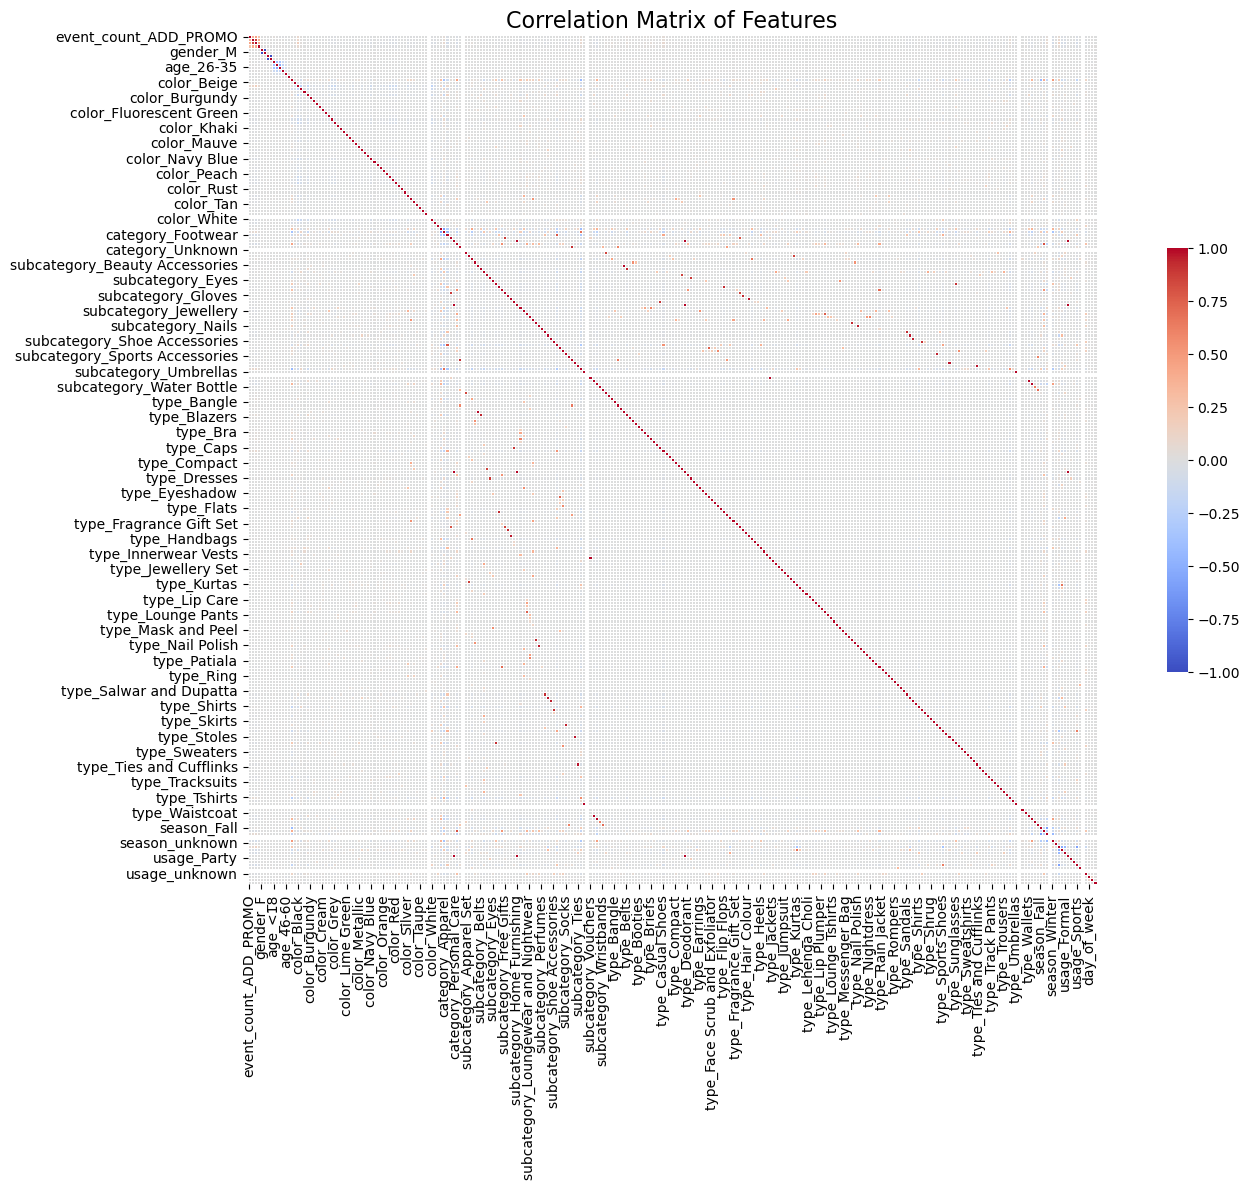

In [18]:
# Visualize Feature Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-feature columns
features_only = df_clean.drop(columns=['session_id', 'label'])

# Compute correlation matrix
corr_matrix = features_only.corr()

# Set up the plot
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Identifying Features Most Correlated with the Target Label
This code calculates the correlation between each feature and the target variable (label) to identify which features are most predictive.

- The session_id column is removed, as it is not a predictive feature.

- Pearson correlation coefficients are computed between all features and the label, and the label’s self-correlation is dropped.

- Correlations are ranked by their absolute values to capture both positive and negative relationships.

- The top 10 most correlated features with the target label are displayed, helping to highlight the strongest predictors for model training.

In [19]:
# Compute correlation with label
df_temp = df_clean.drop(columns=['session_id'])
corr_with_label = df_temp.corr()['label'].drop('label')  # drop self-correlation

# Sort by absolute correlation
top_corr = corr_with_label.abs().sort_values(ascending=False)

# Show top 10 features most correlated with label
print("Top 10 features most correlated with label:")
print(top_corr.head(10))

Top 10 features most correlated with label:
subcategory_Home Furnishing    0.018274
usage_Home                     0.018274
category_Home                  0.018274
type_Cushion Covers            0.018274
week_of_month                  0.014666
subcategory_Bath and Body      0.012879
color_unknown                  0.012840
subcategory_Wristbands         0.009582
type_Heels                     0.009365
color_Charcoal                 0.008979
Name: label, dtype: float64


### Loading Data and Preparing for Visualization
This section imports the final engineered feature dataset (final_project_features.csv) and the model evaluation results (model_results.csv). It ensures the target variable label is correctly typed as integers to facilitate analysis and visualization. The model evaluation results are then printed for review.

In [20]:
# -Load Data and Prepare for Visualization, and also this section imports the final engineered features and the model evaluation results.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('final_project_features.csv')
results = pd.read_csv('model_results.csv')

df['label'] = df['label'].astype(int)
print(results)

                 Model  Accuracy  F1-score       AUC
0  Logistic Regression  0.527716  0.681687  0.512341
1        Random Forest  0.725293  0.838538  0.511011


In [21]:
print(df['label'].value_counts(normalize=True))

label
1    0.666082
0    0.333918
Name: proportion, dtype: float64


### Visualizing Model Performance Comparison
This section reshapes the model evaluation results into a long format to facilitate visualization. Using Seaborn’s bar plot, it compares the performance of different models across evaluation metrics. 

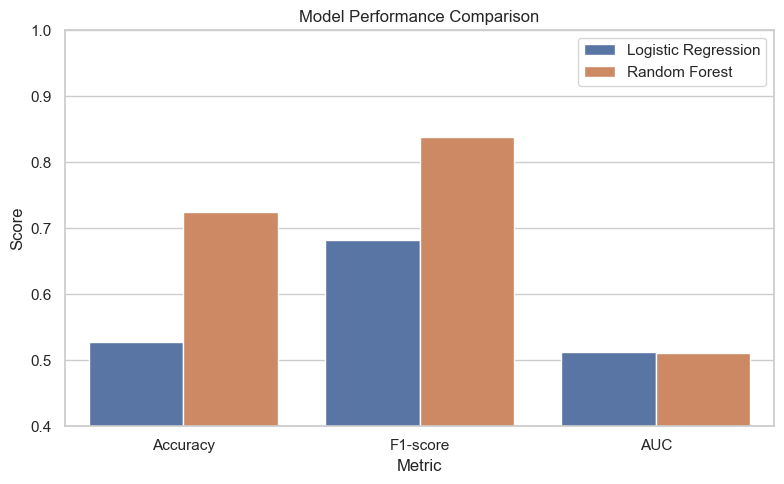

In [22]:
# Visualize Model Performance Comparison

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(8, 5))
sns.barplot(data=results_melted, x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison")
plt.ylim(0.4, 1.0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Visualizing Confusion Matrices
This section generates confusion matrices for the Logistic Regression and Random Forest models to evaluate classification performance in terms of true positives, true negatives, false positives, and false negatives. The matrices are visualized side-by-side using Seaborn heatmaps with color gradients (Blues for Logistic Regression and Greens for Random Forest).



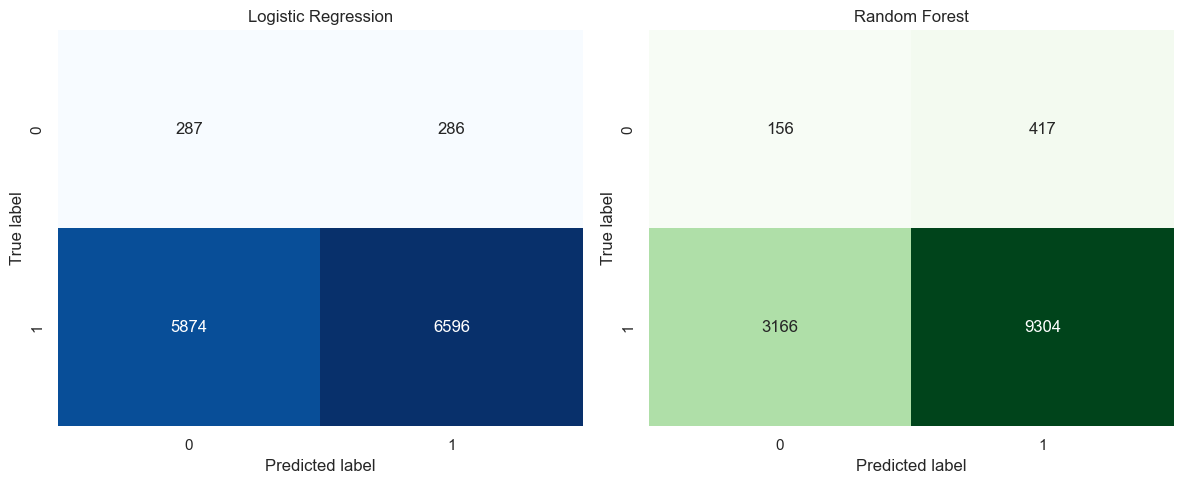

In [23]:
# Visualize Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title("Logistic Regression")
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax[1], cbar=False)
ax[1].set_title("Random Forest")
ax[1].set_xlabel("Predicted label")
ax[1].set_ylabel("True label")

plt.tight_layout()
plt.show()

### Visualization: ROC Curve
This section plots the Receiver Operating Characteristic (ROC) curves for the Logistic Regression and Random Forest models to compare their ability to distinguish between classes. The curves are generated using the models’ predicted probabilities, with the AUC (Area Under Curve) values displayed in the legend for easy reference. 

The plot helps assess each model’s trade-off between sensitivity (True Positive Rate) and specificity (1 − False Positive Rate), with higher AUC values indicating stronger classification performance.

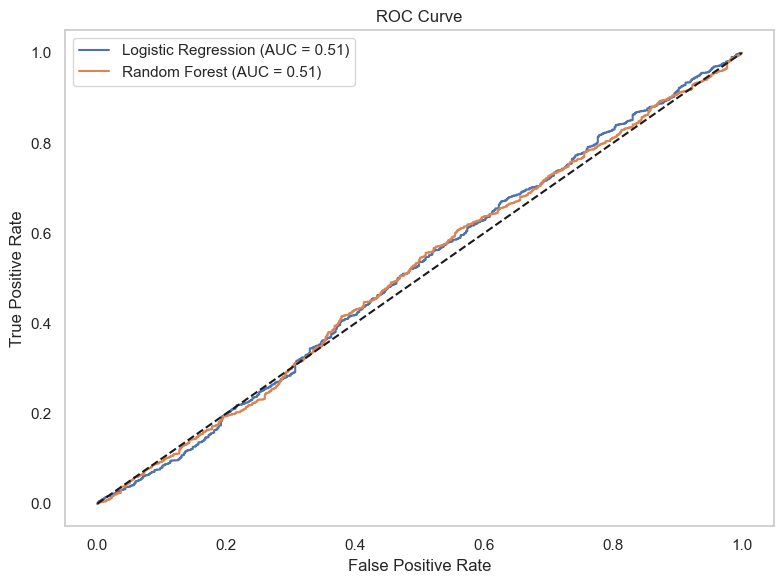

In [24]:
# Visualize ROC Curve

from sklearn.metrics import roc_curve, auc

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Visualization:  Device Type vs Conversion Rate
This plot compares conversion rates between Android and iOS users. The data is normalized within each device category, showing the proportion of users who converted versus those who did not.



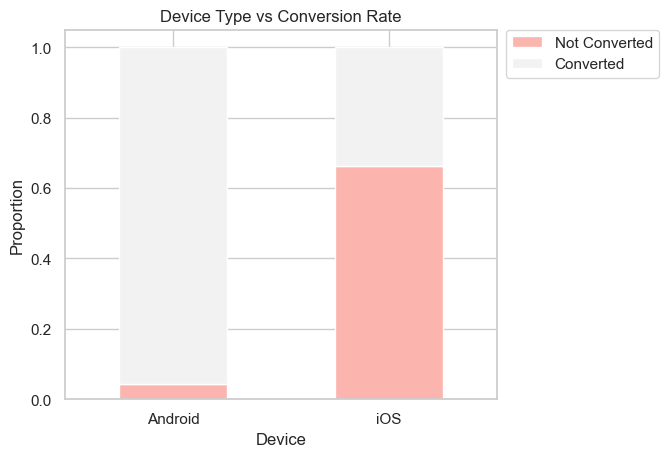

In [25]:
# Visualize Device Type versus Conversion Rate
device_df = df[['device_Android', 'device_iOS', 'label']].copy()
device_df['device'] = device_df.apply(lambda row: 'Android' if row['device_Android']==1 else 'iOS', axis=1)
device_ct = pd.crosstab(device_df['device'], device_df['label'], normalize='index')

device_ct.plot(kind='bar', stacked=True, colormap='Pastel1')
plt.title("Device Type vs Conversion Rate")
plt.ylabel("Proportion")
plt.xlabel("Device")
plt.xticks(rotation=0)
plt.legend(["Not Converted", "Converted"],
           loc='upper left', bbox_to_anchor=(1.02, 1),
           borderaxespad=0.)

plt.subplots_adjust(right=0.8)
plt.show()

### Visualization: Conversion Rate by Hour of Day

This line chart shows the average conversion rate across different hours of the day. Each point represents the mean conversion probability for users active in that hour. The trend helps identify peak engagement times, revealing when users are most likely to convert, which can guide targeted campaign scheduling and resource allocation.

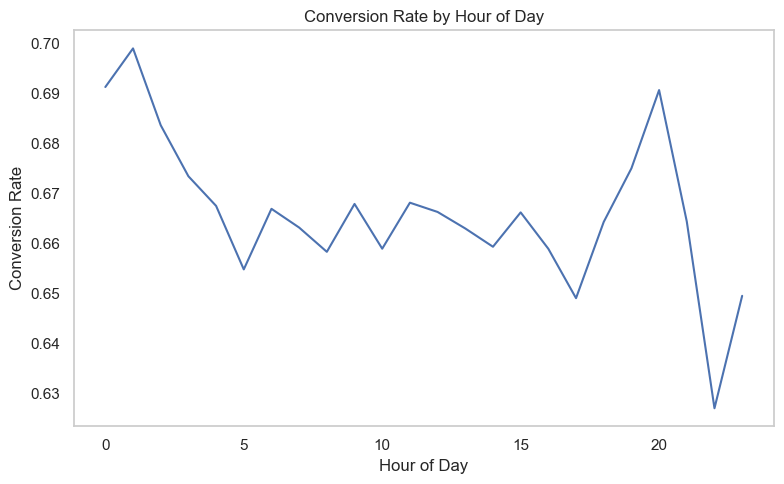

In [26]:
# Visualize Conversion Rate by Hour of Day

conversion_by_hour = df.groupby('hour_of_day')['label'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values)
plt.title("Conversion Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Conversion Rate")
plt.grid()
plt.tight_layout()
plt.show()

### Visualization: Conversion Rate by Day of Week Visualization
This code calculates the mean conversion rate (label) for each day of the week by grouping the data on day_of_week. It then visualizes these average conversion rates using a line plot to show how conversion varies across different weekdays. This helps identify which days have higher or lower user conversion rates.

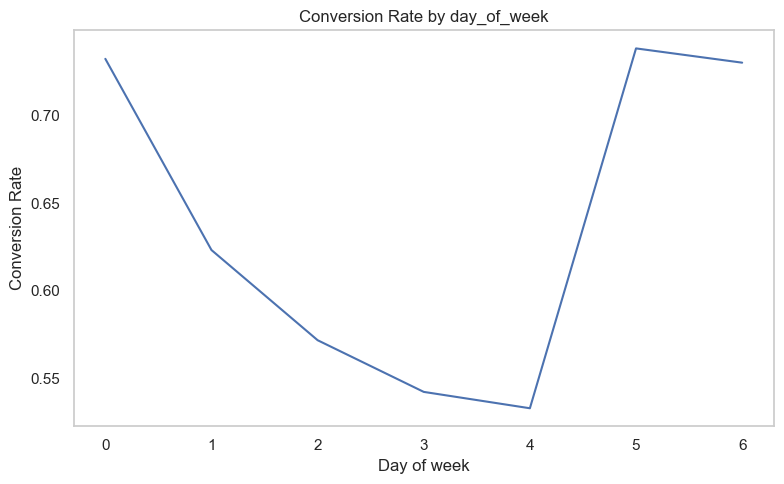

In [27]:
# Visualize Conversion Rate by Day of Week

conversion_by_hour = df.groupby('day_of_week')['label'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values)
plt.title("Conversion Rate by day_of_week")
plt.xlabel("Day of week")
plt.ylabel("Conversion Rate")
plt.grid()
plt.tight_layout()
plt.show()

### Visualization: Conversion Rate by Week of Month Visualization
This code calculates the average conversion rate grouped by the week of the month and visualizes it as a line plot. The chart reveals how user conversion rates fluctuate during different weeks within a month, providing insights into temporal patterns that may affect user behavior or campaign effectiveness.

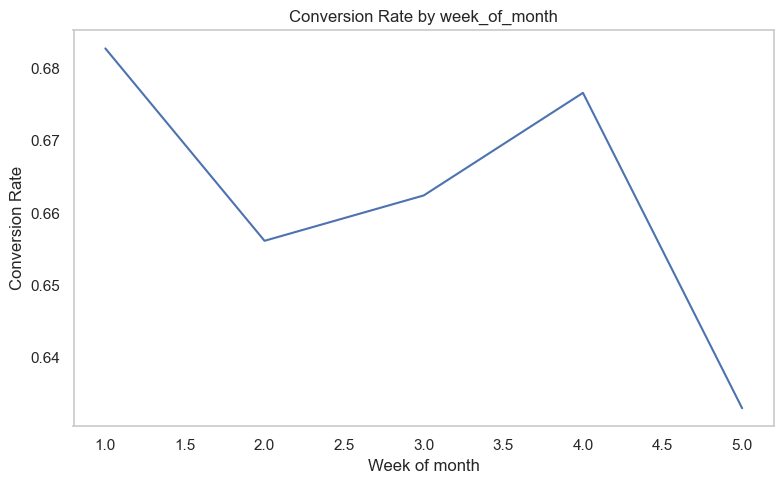

In [28]:
#  Visualize Conversion Rate by Week of Month

conversion_by_hour = df.groupby('week_of_month')['label'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values)
plt.title("Conversion Rate by week_of_month")
plt.xlabel("Week of month")
plt.ylabel("Conversion Rate")
plt.grid()
plt.tight_layout()
plt.show()

### Visualization: Conversion Rate by Product Category Visualization
This code calculates and visualizes the conversion rate for each product category (excluding the unknown category). It iterates over all one-hot encoded category columns, computes the average conversion rate (label) for sessions where the category is present, and stores these rates. The resulting conversion rates are sorted and displayed as a bar chart, highlighting which product categories have higher or lower conversion performance.

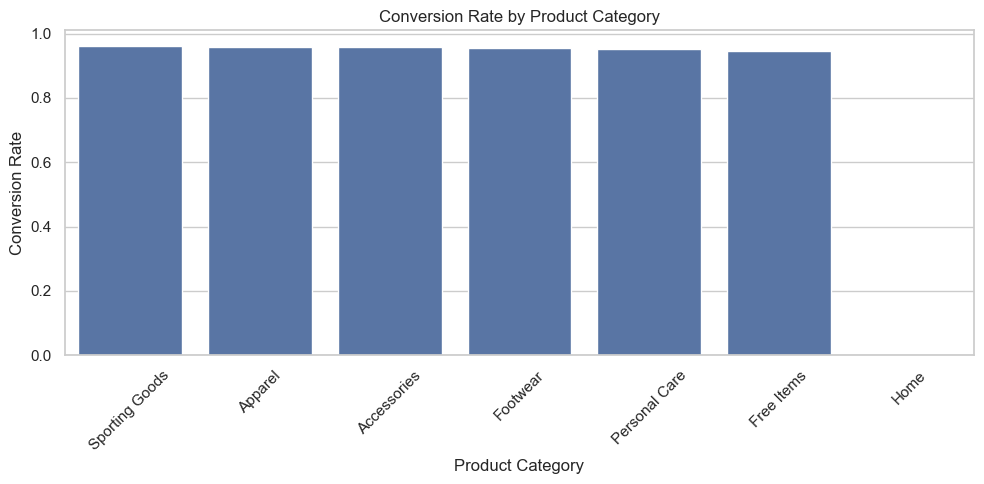

In [29]:
# Visualize Conversion Rate by Product Category

import matplotlib.pyplot as plt
import seaborn as sns

category_cols = [col for col in df.columns if col.startswith('category_') and col != 'category_Unknown']


conversion_rates = {}

#  converted=1 rate
for col in category_cols:
    mask = df[col] == 1
    if mask.sum() > 0:
        rate = df.loc[mask, 'label'].mean()
        conversion_rates[col.replace('category_', '')] = rate


conversion_series = pd.Series(conversion_rates).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=conversion_series.index, y=conversion_series.values)
plt.xticks(rotation=45)
plt.xlabel("Product Category")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Product Category")
plt.tight_layout()
plt.show()


### Visualization: Conversion Rate by Product Color Visualization
This code calculates the average conversion rate for each product color by iterating over one-hot encoded color columns. For each color, it computes the mean conversion (label) among sessions where that color is present. The conversion rates are compiled into a dataframe, sorted in descending order, and visualized with a bar chart to highlight which product colors are associated with higher user conversion.

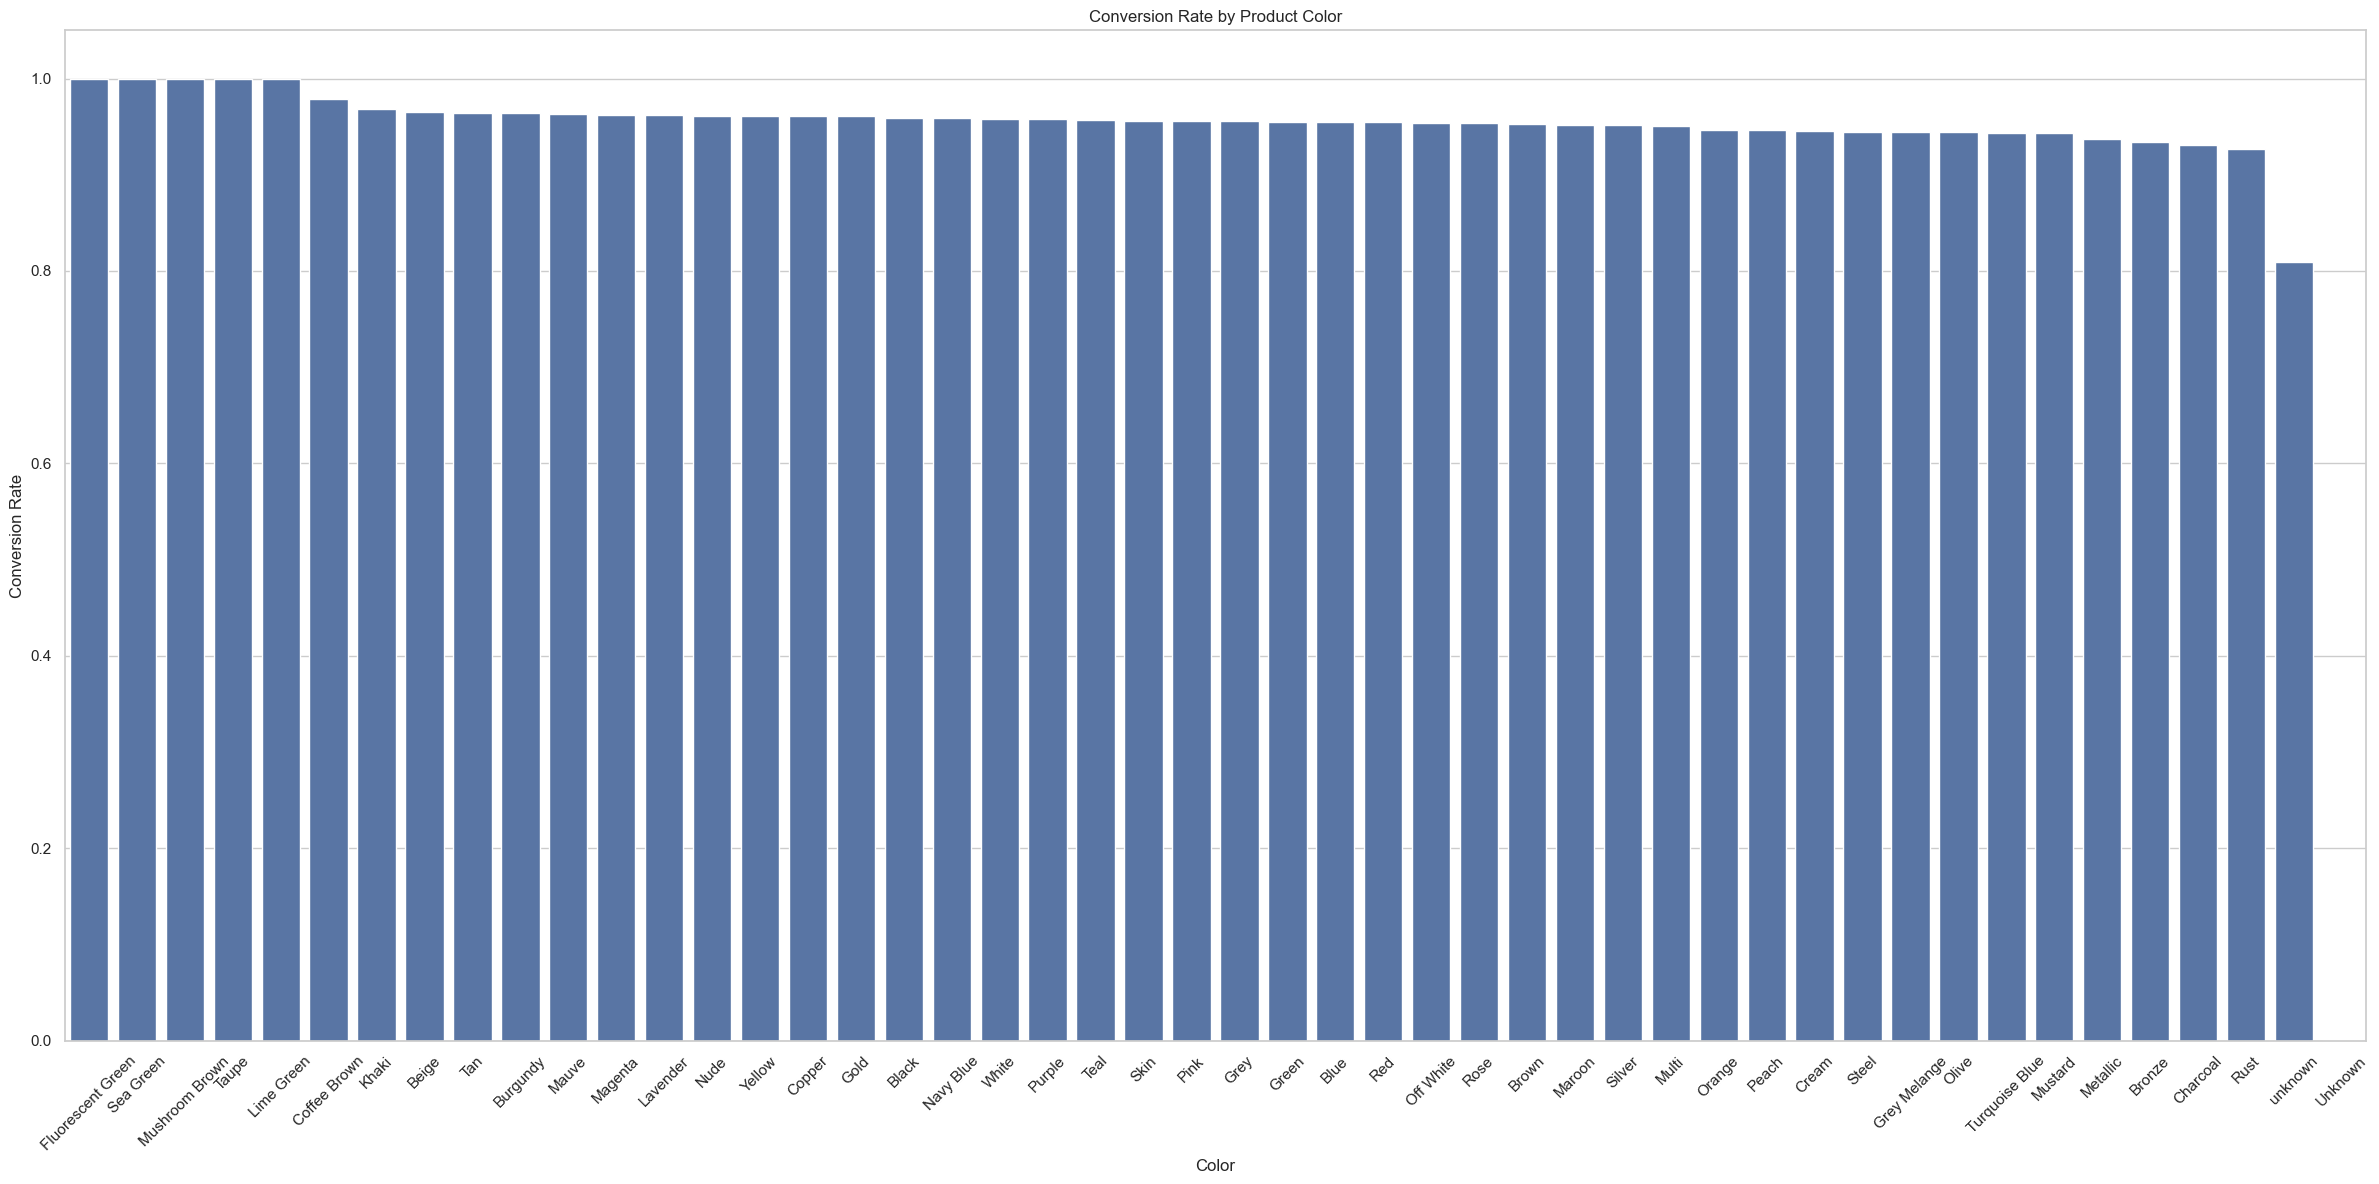

In [30]:
# Visualize Conversion Rate by Product Color

color_cols = [col for col in df.columns if col.startswith('color_')]

color_conversion = {}
for col in color_cols:
    conversion = df[df[col] == 1]['label'].mean()
    color_conversion[col.replace("color_", "")] = conversion

color_df = pd.DataFrame.from_dict(color_conversion, orient='index', columns=['conversion_rate'])
color_df = color_df.sort_values(by='conversion_rate', ascending=False)

plt.figure(figsize=(24, 12))
sns.barplot(x=color_df.index, y=color_df['conversion_rate'])
plt.title("Conversion Rate by Product Color")
plt.xlabel("Color")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
